<a href="https://colab.research.google.com/github/michaeldtz/DialectDetection/blob/master/%5Bmichaeldtz%5D_dialect_detecting_audio_analysis_json.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dialect Detecting Audio Analysis

This notebook contains some experiments to detect German dialects from short audio clips. The data are 20 seconds audio clips with various dialects that have been collected and stored in GCS (https://console.cloud.google.com/storage/browser/dialectdetector-input-data). To start working with the audio files we leverage the librosa library in Python that needs to be installed first. 

## Initialization 
Let's start with some basic preparation work, like mounting the GCS bucket that contains the audio clips using GCS Fuse  and installing librosa. 

In [ ]:
import os
import shutil
import random
import time 

import pandas as pd
import numpy  as np

In [ ]:
# Define the path for the data
data_dir_root = os.getcwd()  + "/dialectdetector-data"
sync_data_locally = True

print ("The directory for the data of the GCS bucket is %s" % data_dir_root)

In [ ]:
# Decide if you want to keep the data on the mounted GCS share or if to copy it locally
sync_data_locally = True

if sync_data_locally:
  
  !mkdir {data_dir_root}
  !mkdir {data_dir_root}/audioclips
  print("Syncing audio clips to local storage")
  !gsutil -m -q rsync -r "gs://dialectdetector-input-data/audioclips" {data_dir_root}/audioclips 

else:
  # Install GCSFuse
  !echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
  !curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
  !apt -qq update
  !apt -qq install gcsfuse
  print("GCSFuse Installed")

  from google.colab import auth
  auth.authenticate_user()

  ## Make a directory name for yor bucket in Colab and mount the bucket at that directory in Colab ##
  if os.path.isdir(data_dir_root) is False:
    !mkdir {data_dir_root}
    !gcsfuse --implicit-dirs dialectdetector-input-data {data_dir_root}
  else:
    print("directory for mount already existing")

!ls {data_dir_root}


In [ ]:
# Install librosa
!sudo apt-get install -y libsndfile1-dev
!pip -qq install librosa

# Test the librosa installation
import librosa
import librosa.display
print("Librosa installed in version " + librosa.__version__)

Let's check the data and plot some initial visualizations that help to understand the data and the various representations (e.g. MFCC)

In [ ]:
# Displays are built with matplotlib 
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')

# Render figures interactively in the notebook
%matplotlib nbagg
%matplotlib inline

# IPython gives us an audio widget for playback
import IPython
from IPython.display import Audio

print("Matplotlib imported and prepared")

In [ ]:
test_file = data_dir_root + "/audioclips/pfaelzisch/6HWUsH27YD0_0.wav"
y, sr = librosa.load(test_file, sr=8500)
print(y.shape, sr)
display(Audio(data=y, rate=sr))

In [ ]:
print(y.mean())
print(y.std())

plt.hist(y, bins='auto')
plt.show()

In [ ]:
plt.figure()
plt.subplot(3, 1, 2)
librosa.display.waveplot(y, sr=sr)
plt.title('Monophonic')

In [ ]:
# Extract the MFCC 
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=120)
print(mfccs.shape)
mfccsMean = np.mean(mfccs.T,axis=0)
print(mfccsMean.shape)

print(mfccs.mean())
print(mfccs.std())
print(mfccsMean.mean())
print(mfccsMean.std())

plt.hist(mfccsMean, bins='auto')
plt.show()


In [ ]:
# Visualize the Mel Spectogram
melspec = librosa.feature.melspectrogram(y=y, sr=sr)
print("melspec is {} long".format(melspec.shape))

db_spec = librosa.power_to_db(melspec, ref=np.max,)
print("db_spec is {} long".format(melspec.shape))
librosa.display.specshow(db_spec,y_axis='mel', x_axis='s', sr=sr)
plt.colorbar();

## Data Preparation
Now lets download the audio clips and organize them as needed for the first training challenge. For a proper and efficient colab usage we set up a local mount to a drive and synchronize the content from its original google cloud storage location to the drive mount. 

In [ ]:
# Count files by folder
audioclip_dir = data_dir_root + "/audioclips"
folders = sorted(os.listdir(audioclip_dir))
all_files = []
files_by_dialect = {
    "pfaelzisch" : [],
    "non-pfaelzisch" : []
}

for folder in folders:
    files = os.listdir(audioclip_dir + "/" + folder)
    print("{}: {}".format(folder,len(files)))

    for file in files:
        entry = {
            "name"    : file,
            "dialect" : folder,
            "path"    : audioclip_dir + "/" + folder + "/" + file
        }
        
        all_files.append(entry)        
        if folder == "pfaelzisch":
            files_by_dialect["pfaelzisch"].append(entry)
        else:
            files_by_dialect["non-pfaelzisch"].append(entry)


print("total: {}".format(len(all_files)))
print("total pfaelzisch: {}".format(len(files_by_dialect["pfaelzisch"])))
print("total non-pfaelzisch: {}".format(len(files_by_dialect["non-pfaelzisch"])))

In the very first experiements we want to create a simple binary classifier. Therefore we create only two classes: pfalzisch and non-pfaelzisch. Both have around 1500 audioclips (a 10 seconds). The next steps catorizes them into two classes, takes 1500 of each and shuffles them into train, test and validation data sets.

In [ ]:
# Lets take the top 1500 per dataset, randomize and split into train, test, val 
ds_pfl = files_by_dialect["pfaelzisch"][:1500]
ds_npf = files_by_dialect["non-pfaelzisch"][:1500]

random.shuffle(ds_pfl)
random.shuffle(ds_npf)

ds_pfl_train = ds_pfl[:1000]
ds_pfl_test  = ds_pfl[1000:1250]
ds_pfl_val   = ds_pfl[1250:1500]

ds_npf_train = ds_npf[:1000]
ds_npf_test  = ds_npf[1000:1250]
ds_npf_val   = ds_npf[1250:1500]

ds_mean      = { "all": ds_pfl[900:1100] + ds_npf[900:1100] }

datasets = {
    "train" : {
        "pfl" : ds_pfl_train,
        "npf" : ds_npf_train
    },
    "test"  : {
        "pfl" : ds_pfl_test, 
        "npf" : ds_npf_test
    },
    "val" :   {
        "pfl" : ds_pfl_val,
        "npf" : ds_npf_val 
    }
}

print("some examples out of the created datasets")
print(datasets["train"]["pfl"][104])
print(datasets["test"]["npf"][76])

## Technical Preparation
In the next step we implement a little data Generator class for Keras that simplifies the handling of data access for the training and validation.

In [ ]:
import os
import librosa

import numpy as np
import keras

class AudioDataGenerator(keras.utils.Sequence):

    def __init__(self, fileList, labels, batch_size=32, sr=8500, dim=None, n_classes=2, n_split=1, audio_rep="default", audio_rep_params={}, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.fileList = fileList
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.sr = sr
        self.audio_rep = audio_rep
        self.audio_rep_params = audio_rep_params
        self.n_split = n_split
        self.norm_mean = 0
        self.norm_devi  = 1

        if self.dim == None:
          self.__determine_dim__()
          

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.fileList) / self.batch_size))
    
  
    def __getitem__(self, index):
        #print("Generator: start loading batch #{}".format(index))
        start_ts = int(round(time.time() * 1000))
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of filenames
        files_in_batch = [self.fileList[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(files_in_batch)

        time_to_load = int((int(round(time.time() * 1000)) - start_ts)/1000)
        #print("Generator: Loaded audio data #{} in {} seconds".format(index,time_to_load))

        return X, y

    def on_epoch_end(self):
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.fileList))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def normalize(self,sampleBatches=20,deviation_type=None):
        self.norm_mean = 0
        self.norm_devi = 1
        
        values = []

        for i in range(0,sampleBatches):
          #print("normalization batch {} of {} ".format(i,sampleBatches))
          x,y = self.__getitem__(i)
          values = np.concatenate((values,x.flatten()))

        self.norm_mean = np.mean(values)

        if deviation_type == "max":
          self.norm_devi = np.max(np.abs(values))
        else:
          self.norm_devi = np.std(values)

        return { "mean" : self.norm_mean, "deviation": self.norm_devi }
    
    def set_normalization(self, mean, deviation):
        self.norm_mean = mean
        self.norm_devi = deviation

    def __determine_dim__(self):
        data = self.__loadaudiodata__(self.fileList[0]["path"])
        
        if len(data.shape) == 1:
          self.dim = (data.shape[0],)
        else:
          self.dim = data.shape

    def __loadaudiodata__(self, filepath):
        #print("Loading file {}".format(filepath))
        data, sr = librosa.load(filepath, sr=self.sr)

        if self.audio_rep == "default":
          data = (data - self.norm_mean) / self.norm_devi
          return data
        elif self.audio_rep == "mfccs" or self.audio_rep == "mfccs_meaned":
          mfccs = librosa.feature.mfcc(y=data, sr=sr, **self.audio_rep_params)
          #print("Shape of mfccs", mfccs.shape)

          if self.audio_rep == "mfccs_meaned":
            mfccs = np.mean(mfccs.T,axis=0)
            mfccs = ( mfccs - self.norm_mean ) / self.norm_devi
          else:
            mfccs = ( mfccs - self.norm_mean ) / self.norm_devi


          return mfccs

    def __data_generation(self, files):
        # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, fileinfo in enumerate(files):
            
            # Load audio file and store values
            data = self.__loadaudiodata__(fileinfo["path"])
            X[i,] = data.reshape(*self.dim)

            # Store class
            y[i] = self.labels[fileinfo["name"]]
        
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

    @staticmethod
    def factory(filelist,classes,batch_size=32,dim=None,n_split=1,audio_rep="default",audio_rep_params={},shuffle=True):
        
        all_files  = []
        all_labels = {}

        for classIdx,classs in enumerate(classes):
            
            for file in filelist[classs]:
                all_files.append(file)
                all_labels[file["name"]] = classIdx
        
        return  AudioDataGenerator(all_files,all_labels,batch_size=batch_size,dim=dim,n_classes=len(classes),n_split=n_split,audio_rep=audio_rep,audio_rep_params=audio_rep_params,shuffle=shuffle)

print("Audiogenerator class created and ready to use")

check_generator = AudioDataGenerator.factory(datasets["train"],("pfl","npf"),batch_size=1,audio_rep="mfccs",audio_rep_params={"n_mfcc":128},dim=(128*167,1))
x,y = check_generator.__getitem__(0)

print(x.shape)


In [ ]:
# for normalization calculate mean and std over a subset of data using raw audio data
norm_generator_raw= AudioDataGenerator.factory(ds_mean,("all",))
norm_params_raw   = norm_generator_raw.normalize(sampleBatches=3)

print(norm_params_raw)

# for normalization calculate mean and std over a subset of data using MFCCS
norm_generator_mfccs = AudioDataGenerator.factory(ds_mean,("all",),audio_rep="mfccs",audio_rep_params={"n_mfcc":128},dim=(128*167,1))
norm_params_mfccs    = norm_generator_mfccs.normalize(sampleBatches=3)

print(norm_params_mfccs)

In [ ]:
# Check the raw audio data normalization
norm_generator_raw_check = AudioDataGenerator.factory(ds_mean,("all",),batch_size=1)
norm_generator_raw_check.set_normalization(**norm_params_raw)
x,y = norm_generator_raw_check.__getitem__(0)
plt.hist(x[0], bins='auto')
plt.show()

# Check the MFCCS normalization
norm_generator_mfccs_check = AudioDataGenerator.factory(ds_mean,("all",),batch_size=1,audio_rep="mfccs",audio_rep_params={"n_mfcc":128},dim=(128*167,1))
norm_generator_mfccs_check.set_normalization(**norm_params_mfccs)

x,y = norm_generator_mfccs_check.__getitem__(0)
plt.hist(x[0].reshape(21376), bins='auto')
plt.show()

In [ ]:
# Test the normalization
valuesG1 = list(filter(lambda x: x < -1  or  x > 1, x[0]))
valuesI1 = list(filter(lambda x: x >= -1 and x <= 1, x[0]))
print(len(valuesG1))
print(len(valuesI1))
print(len(x[0]))
print(valuesG1)

print(x[0].mean())
print(x[0].std())

In [ ]:
# import Keras 
import keras 
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K

# Prepare a function to plot the accuracy
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')

def plotTrainingResults(history,key):
    plt.clf()
    trn_acc = history[key]
    val_acc = history["val_" + key]
    
    epochs = range(1, len(trn_acc)+1)
    
    plt.plot(epochs, trn_acc,'bo', label="train")
    plt.plot(epochs, val_acc,'b',  label="val")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

print("ready to build models")

## Training a Fully Connected NN

In this chapter we explore how a FCNN is able to handle this challenge.

In [ ]:
# Set the parameters
batch_size = 32
steps_per_epoch=10
epochs=20

audio_rep = "mfccs"
audio_rep_params = { "n_mfcc": 128 }
t_per_mfcss = 167
input_dim=(audio_rep_params["n_mfcc"]*t_per_mfcss,)

# Prepare the audio generators
train_generator = AudioDataGenerator.factory(datasets["train"],("pfl","npf"),dim=input_dim,batch_size=batch_size,audio_rep=audio_rep ,audio_rep_params=audio_rep_params)
valid_generator = AudioDataGenerator.factory(datasets["val"]  ,("pfl","npf"),dim=input_dim,batch_size=batch_size,audio_rep=audio_rep ,audio_rep_params=audio_rep_params)
print("Checking the dims of both generators: train has {}, val has {}".format(train_generator.dim,valid_generator.dim))

train_generator.set_normalization(**norm_params_mfccs)
valid_generator.set_normalization(**norm_params_mfccs)

# Resets the layer idx
K.clear_session()

# Design model
model = Sequential()
model.add(Dense(64,  activation='relu', input_shape=input_dim))
model.add(Dense(32,   activation='relu'))
model.add(Dense(16,   activation='relu'))
model.add(Dense(2,   activation='sigmoid'))


model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

# Train model on dataset
history = model.fit_generator(steps_per_epoch=steps_per_epoch,epochs=epochs,generator=train_generator,validation_data=valid_generator,validation_steps=steps_per_epoch,workers=0,use_multiprocessing=True)

print(history.history)
plotTrainingResults(history.history,"accuracy")  

In [ ]:
print(history.history)
plotTrainingResults(history.history,"loss")  

## Training a Convolutional NN

After the fully connected NN I try to train a convolutional network using Conv1D layers. This has been inspired by a model found on kaggle (https://www.kaggle.com/kcs93023/keras-sequential-conv1d-model-classification)

Checking the dims of both generators: train has (21376, 1), val has (21376, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 21366, 8)          96        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10683, 8)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10677, 16)         912       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5338, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 5334, 32)          2592      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 2667, 32)          0         
_________________________________________

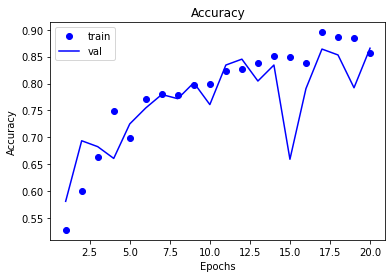

In [ ]:
# The model gets created

from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import backend as K

# Set the parameters
batch_size = 32
steps_per_epoch=10
epochs=20

audio_rep = "mfccs"
audio_rep_params = { "n_mfcc": 128 }
t_per_mfcss = 167
input_dim=(audio_rep_params["n_mfcc"]*t_per_mfcss,1)

# Prepare the audio generators
train_generator = AudioDataGenerator.factory(datasets["train"],("pfl","npf"),dim=input_dim,batch_size=batch_size,audio_rep=audio_rep ,audio_rep_params=audio_rep_params)
valid_generator = AudioDataGenerator.factory(datasets["val"]  ,("pfl","npf"),dim=input_dim,batch_size=batch_size,audio_rep=audio_rep ,audio_rep_params=audio_rep_params)
print("Checking the dims of both generators: train has {}, val has {}".format(train_generator.dim,valid_generator.dim))

train_generator.set_normalization(**norm_params_mfccs)
valid_generator.set_normalization(**norm_params_mfccs)

# Resets the layer idx
K.clear_session()

dr_rate = 0.5

# Design model
model = Sequential()
model.add(layers.Conv1D(8, 11, padding='valid', activation="relu", strides=1, input_shape=input_dim))
model.add(layers.MaxPooling1D(2))
#model.add(layers.Dropout(dr_rate))

model.add(layers.Conv1D(16, 7, padding='valid', activation="relu", strides=1))
model.add(layers.MaxPooling1D(2))
#model.add(layers.Dropout(dr_rate))

model.add(layers.Conv1D(32, 5, padding='valid', activation="relu", strides=1))
model.add(layers.MaxPooling1D(2))
#model.add(layers.Dropout(dr_rate))

model.add(layers.Conv1D(64, 5, padding='valid', activation="relu", strides=1))
model.add(layers.MaxPooling1D(2))
#model.add(layers.Dropout(dr_rate))

model.add(layers.Conv1D(128, 3, padding='valid', activation="relu", strides=1))
model.add(layers.MaxPooling1D(2))
model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dropout(dr_rate))
model.add(layers.Dense(16, activation='relu'))
#model.add(layers.Dropout(dr_rate))

model.add(layers.Dense(2, activation='sigmoid'))

model.compile(optimizers.rmsprop(lr=0.001),loss="binary_crossentropy",metrics=["accuracy"])
model.summary()


# Train model on dataset
history = model.fit_generator(steps_per_epoch=steps_per_epoch,epochs=epochs,generator=train_generator,validation_data=valid_generator,validation_steps=steps_per_epoch,workers=0,use_multiprocessing=True)

print(history.history)
plotTrainingResults(history.history,"accuracy")  

{'val_loss': [0.6863658428192139, 0.6643857359886169, 0.6620668172836304, 0.7594118714332581, 0.6036512851715088, 0.5848864912986755, 0.5080857276916504, 0.600480318069458, 0.4353070557117462, 0.5195097923278809, 0.4192662239074707, 0.3536035418510437, 0.5319163799285889, 0.4542235732078552, 0.7698018550872803, 0.5137921571731567, 0.3750050663948059, 0.29175928235054016, 0.628981351852417, 0.3538880944252014], 'val_accuracy': [0.581250011920929, 0.6937500238418579, 0.682812511920929, 0.660937488079071, 0.7250000238418579, 0.754687488079071, 0.7796875238418579, 0.7718750238418579, 0.801562488079071, 0.760937511920929, 0.8343750238418579, 0.8453124761581421, 0.8046875, 0.8343750238418579, 0.659375011920929, 0.7906249761581421, 0.864062488079071, 0.8531249761581421, 0.792187511920929, 0.8656250238418579], 'loss': [0.8849440574645996, 0.6766503095626831, 0.6549485802650452, 0.5616808980703354, 0.5703045010566712, 0.47694709002971647, 0.47200666964054105, 0.4773730307817459, 0.4586369752883

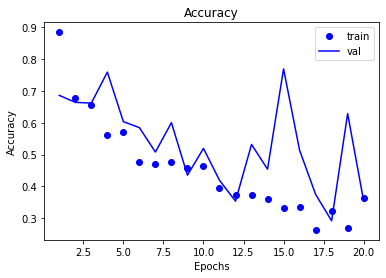

In [ ]:
print(history.history)
plotTrainingResults(history.history,"loss")  

In [ ]:
model.save(data_dir_root + "/cnn")



---


## Appendix: Model Results
The following chapter collects the results of various model experiements



## Further Ideas

* Try a binary classification for a smaller set of dialects (Pfaelzisch vs. Englisch)
* Check the models and data for language detection in general (Google LID5M)
* Standardization with max() not std() 



## Sources and Pointers

- https://towardsdatascience.com/how-to-apply-machine-learning-and-deep-learning-methods-to-audio-analysis-615e286fcbbc